In [23]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, SimpleRNN, LSTM, GRU, Dropout, Activation, Maximum
from tensorflow.python.keras.layers.embeddings import Embedding
from tensorflow.keras import optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import Callback, EarlyStopping
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
dataset_path="stanfordSentimentTreebank/datasetSentences.txt"
pos_path="rt-polaritydata.tar.gz/rt-polaritydata/rt-polarity.pos"
neg_path="rt-polaritydata.tar.gz/rt-polaritydata/rt-polarity.neg"
split_path="stanfordSentimentTreebank/datasetSplit.txt"

raw_dataset = pd.read_table(dataset_path)
pos_reviews = pd.read_table(pos_path,encoding="ISO-8859-1")
neg_reviews = pd.read_table(neg_path,encoding="ISO-8859-1")
split_data = pd.read_table(split_path,delimiter=',')

In [4]:
#Preprocessing data and label data separately
dataset=[]
for i in range(len(raw_dataset)):
    line=raw_dataset['sentence'][i]
    line = line.strip('\r\n\t')
    line = line.replace("`` ","")
    line = line.replace(" ''","")
    line = line.replace(" '","'")
    line = line.replace("` ","")
    #line = line.replace(" '","")
    line = line.lower()
    #print(line)
    dataset.append(line)
np.asarray(dataset)


processed_pos=[]
for i in range(len(pos_reviews)):
    line=pos_reviews['pos'][i]
    line = line.strip('\r\n\t')
    line = line.replace("\" ","")
    line = line.replace(" \"","")
    if line[0]==' ':
        line=line[1:]
    line=line[:-1]
    line=line.replace(". . .","...")
    line = line.lower()
    #print(line)
    processed_pos.append(line)
np.asarray(processed_pos)

processed_neg=[]
for i in range(len(neg_reviews)):
    line=neg_reviews['pos'][i]
    line = line.strip('\r\n\t')
    line = line.replace("\" ","")
    line = line.replace(" \"","")
    if line[0]==' ':
        line=line[1:]
    line=line[:-1]
    line=line.replace(". . .","...")
    line = line.lower()
    #print(line)
    processed_neg.append(line)
np.asarray(processed_neg)

array(['simplistic , silly and tedious .',
       "it's so laddish and juvenile , only teenage boys could possibly find it funny .",
       'exploitative and largely devoid of the depth or sophistication that would make watching such a graphic treatment of the crimes bearable .',
       ...,
       "as it stands , crocodile hunter has the hurried , badly cobbled look of the 1959 godzilla , which combined scenes of a japanese monster flick with canned shots of raymond burr commenting on the monster's path of destruction .",
       'the thing looks like a made-for-home-video quickie .',
       "enigma is well-made , but it's just too dry and too placid ."],
      dtype='<U260')

In [5]:
#Mapping cornell training data to stanford training data
count1=0
count2=0
all_labels=[]
all_data=[]
dataset_indices=[]
for i in range(len(dataset)):
    if dataset[i] in processed_pos:
        all_data.append(dataset[i])
        all_labels.append(1)
        dataset_indices.append(i+1)
        count1=count1+1

for i in range(len(dataset)):
    if dataset[i] in processed_neg:
        all_data.append(dataset[i])
        all_labels.append(0)
        dataset_indices.append(i+1)
        count2=count2+1

In [6]:
#Removing Punctuation
for a in range(len(all_data)):
    all_data[a]=all_data[a].replace(" .","")
    all_data[a]=all_data[a].replace(" ,","")
np.asarray(all_data)
np.asarray(all_labels)

array([1, 1, 1, ..., 0, 0, 0])

In [7]:
###splitting all_data
training_data=[]
training_label=[]
test_data=[]
test_label=[]
dev_data=[]
dev_label=[]
for ii in range(len(split_data)):
    sentence_idx=split_data['sentence_index'][ii]
    if sentence_idx in dataset_indices:
        ix=dataset_indices.index(sentence_idx)
        if split_data['splitset_label'][ii]==1:     #train
            training_data.append(all_data[ix])
            training_label.append(all_labels[ix])
        if split_data['splitset_label'][ii]==2:     #test
            test_data.append(all_data[ix])
            test_label.append(all_labels[ix])
        if split_data['splitset_label'][ii]==3:     #dev
            dev_data.append(all_data[ix])
            dev_label.append(all_labels[ix])


In [8]:
###randomizing
training_data_nonRandomized=training_data
training_label_nonRandomized=training_label
num_samples = len(training_data)
all_idx = list(range(num_samples))
random.shuffle(all_idx)
training_data = [training_data_nonRandomized[ii] for ii in all_idx]
training_label = [training_label_nonRandomized[ii] for ii in all_idx]

###randomizing
test_data_nonRandomized=test_data
test_label_nonRandomized=test_label
num_samples = len(test_data)
all_idx2 = list(range(num_samples))
random.shuffle(all_idx2)
test_data = [test_data_nonRandomized[ii] for ii in all_idx2]
test_label = [test_label_nonRandomized[ii] for ii in all_idx2]

###randomizing
dev_data_nonRandomized=dev_data
dev_label_nonRandomized=dev_label
num_samples = len(dev_data)
all_idx3 = list(range(num_samples))
random.shuffle(all_idx3)
dev_data = [dev_data_nonRandomized[ii] for ii in all_idx3]
dev_label = [dev_label_nonRandomized[ii] for ii in all_idx3]

###randomizing done

In [9]:
for sentence in range(len(training_data)):
    training_data[sentence]=text_to_word_sequence(training_data[sentence])

for sentence in range(len(test_data)):
    test_data[sentence]=text_to_word_sequence(test_data[sentence])
    
for sentence in range(len(dev_data)):
    dev_data[sentence]=text_to_word_sequence(dev_data[sentence])

In [10]:
#list to np
training_data=np.asarray(training_data)
training_label=np.asarray(training_label).reshape((len(training_label),1))
test_data=np.asarray(test_data)
test_label=np.asarray(test_label).reshape((len(test_label),1))
dev_data=np.asarray(dev_data)
dev_label=np.asarray(dev_label).reshape((len(dev_label),1))

In [142]:
#glove to dictionary
words = []
idx = 0
word2idx = {}
embeddings_index = dict()
count=0
print("Glove to dictionary")
with open(f'glove/glove.6B.300d.txt', 'rb') as f:
    for line in f:
        count+=1
        if count==50000:
            print(count)
        if count==200000:
            print(count)
        if count==400000:
            print(count," Done")
        values = line.decode().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

Glove to dictionary
50000
200000
400000  Done


In [43]:
### TEXT TO SEQUENCING    
vocabulary_size = 100000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(training_data)

train_sequences = tokenizer.texts_to_sequences(training_data)

train_sequences = pad_sequences(train_sequences, maxlen=55)

#######
test_sequences = tokenizer.texts_to_sequences(test_data)

test_sequences = pad_sequences(test_sequences, maxlen=55)
#######
dev_sequences = tokenizer.texts_to_sequences(dev_data)

dev_sequences = pad_sequences(dev_sequences, maxlen=55)
#######

In [44]:
#Creating embedding matrix
num_words = 100000
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
#Models and Plots

In [45]:
################################## Model for Vanilla RNN ############################## 
cb = Callback()
cb_list = [cb]
es = EarlyStopping(monitor='val_accuracy', mode='max')
def vanilla_rnn():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 300, input_length=55, weights=[embedding_matrix], trainable=False))
    model.add(SimpleRNN(200, return_sequences = False))
    model.add(Dense(units=100, input_dim = 200, activation='sigmoid'))
    model.add(Dense(units=50, input_dim=100, activation='sigmoid'))
    model.add(Dense(units=1, input_dim=50,activation='sigmoid'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

model = KerasClassifier(build_fn = vanilla_rnn, epochs = 6, batch_size = 50, verbose = 1)

historyRNN=model.fit(train_sequences, training_label,validation_data=(dev_sequences,dev_label),callbacks=cb_list)
##################################          END          ############################## 

Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 10s 2ms/sample - loss: 0.6515 - acc: 0.6214 - val_loss: 0.5902 - val_acc: 0.7020
Epoch 2/6
5402/5402 [==============================] - 9s 2ms/sample - loss: 0.5714 - acc: 0.7025 - val_loss: 0.6207 - val_acc: 0.6709
Epoch 3/6
5402/5402 [==============================] - 9s 2ms/sample - loss: 0.5225 - acc: 0.7464 - val_loss: 0.4768 - val_acc: 0.7698
Epoch 4/6
5402/5402 [==============================] - 9s 2ms/sample - loss: 0.5977 - acc: 0.6886 - val_loss: 0.6660 - val_acc: 0.6031
Epoch 5/6
5402/5402 [==============================] - 9s 2ms/sample - loss: 0.4968 - acc: 0.7684 - val_loss: 0.5149 - val_acc: 0.7401
Epoch 6/6
5402/5402 [==============================] - 9s 2ms/sample - loss: 0.4487 - acc: 0.7975 - val_loss: 0.5159 - val_acc: 0.7415


In [46]:
################################## Model for LSTM #####################################
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 300, input_length=55, 
                          weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))

model_glove.add(LSTM(200))
model_glove.add(Dense(units=100, input_dim = 200, activation='sigmoid'))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
historyLSTM=model_glove.fit(train_sequences,training_label,epochs=6,validation_data=(dev_sequences,dev_label))
##################################          END          ##############################

Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 74s 14ms/sample - loss: 0.5586 - acc: 0.7062 - val_loss: 0.4637 - val_acc: 0.7867
Epoch 2/6
5402/5402 [==============================] - 81s 15ms/sample - loss: 0.4664 - acc: 0.7730 - val_loss: 0.4530 - val_acc: 0.7895
Epoch 3/6
5402/5402 [==============================] - 76s 14ms/sample - loss: 0.4180 - acc: 0.8062 - val_loss: 0.4267 - val_acc: 0.8023
Epoch 4/6
5402/5402 [==============================] - 71s 13ms/sample - loss: 0.3713 - acc: 0.8223 - val_loss: 0.4450 - val_acc: 0.7910
Epoch 5/6
5402/5402 [==============================] - 72s 13ms/sample - loss: 0.3243 - acc: 0.8549 - val_loss: 0.4521 - val_acc: 0.8051
Epoch 6/6
5402/5402 [==============================] - 73s 13ms/sample - loss: 0.2696 - acc: 0.8819 - val_loss: 0.5384 - val_acc: 0.7797


In [47]:
################################## Model for GRU      #################################
modelGRU = Sequential()
modelGRU.add(Embedding(vocabulary_size, 300, input_length=55, weights=[embedding_matrix], trainable=False))
modelGRU.add(GRU(25))
modelGRU.add(Dense(1, activation='sigmoid'))
modelGRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
historyGRU=model.fit(train_sequences, training_label,validation_data=(dev_sequences,dev_label), epochs=6)
##################################          END          ##############################

Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 11s 2ms/sample - loss: 0.6568 - acc: 0.6042 - val_loss: 0.6084 - val_acc: 0.6653
Epoch 2/6
5402/5402 [==============================] - 9s 2ms/sample - loss: 0.5666 - acc: 0.7157 - val_loss: 0.5658 - val_acc: 0.7260
Epoch 3/6
5402/5402 [==============================] - 9s 2ms/sample - loss: 0.5661 - acc: 0.7081 - val_loss: 0.5905 - val_acc: 0.6653
Epoch 4/6
5402/5402 [==============================] - 9s 2ms/sample - loss: 0.5685 - acc: 0.7066 - val_loss: 0.6184 - val_acc: 0.6751
Epoch 5/6
5402/5402 [==============================] - 9s 2ms/sample - loss: 0.5929 - acc: 0.6814 - val_loss: 0.6569 - val_acc: 0.6243
Epoch 6/6
5402/5402 [==============================] - 9s 2ms/sample - loss: 0.5746 - acc: 0.7027 - val_loss: 0.5623 - val_acc: 0.7020


RNN Plot
LSTM Plot
GRU Plot
       loss       acc  val_loss   val_acc  epoch
0  0.656789  0.604221  0.608391  0.665254      0
1  0.566630  0.715661  0.565847  0.725989      1
2  0.566099  0.708071  0.590471  0.665254      2
3  0.568487  0.706590  0.618408  0.675141      3
4  0.592948  0.681414  0.656879  0.624294      4
5  0.574645  0.702703  0.562324  0.701977      5


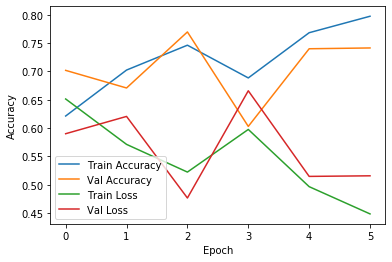

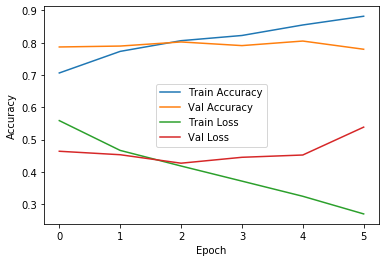

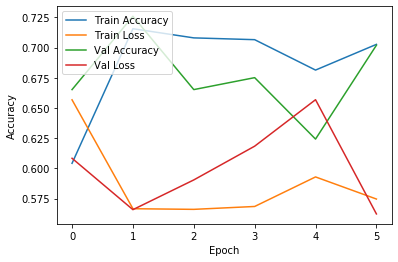

In [48]:
################################## Graphs #############################################
print("RNN Plot")
histRNN = pd.DataFrame(historyRNN.history)
histRNN['epoch'] = historyRNN.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(histRNN['epoch'], histRNN['acc'],
         label='Train Accuracy')
plt.plot(histRNN['epoch'], histRNN['val_acc'],
         label = 'Val Accuracy')
plt.plot(histRNN['epoch'], histRNN['loss'],
         label='Train Loss')
plt.plot(histRNN['epoch'], histRNN['val_loss'],
         label = 'Val Loss')
plt.legend()

print("LSTM Plot")
histLSTM = pd.DataFrame(historyLSTM.history)
histLSTM['epoch'] = historyLSTM.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(histLSTM['epoch'], histLSTM['acc'],
         label='Train Accuracy')
plt.plot(histLSTM['epoch'], histLSTM['val_acc'],
         label = 'Val Accuracy')
plt.plot(histLSTM['epoch'], histLSTM['loss'],
         label='Train Loss')
plt.plot(histLSTM['epoch'], histLSTM['val_loss'],
         label = 'Val Loss')
plt.legend()

print("GRU Plot")
histGRU = pd.DataFrame(historyGRU.history)
histGRU['epoch'] = historyGRU.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
print (histGRU)
plt.plot(histGRU['epoch'], histGRU['acc'],
         label='Train Accuracy')
plt.plot(histGRU['epoch'], histGRU['loss'],
         label='Train Loss')
plt.plot(histGRU['epoch'], histGRU['val_acc'],
         label = 'Val Accuracy')
plt.plot(histGRU['epoch'], histGRU['val_loss'],
         label = 'Val Loss')
plt.legend()

Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 9s 2ms/sample - loss: 0.6410 - acc: 0.6188 - val_loss: 0.5501 - val_acc: 0.7345
Epoch 2/6
5402/5402 [==============================] - 7s 1ms/sample - loss: 0.5601 - acc: 0.7188 - val_loss: 0.4936 - val_acc: 0.7782
Epoch 3/6
5402/5402 [==============================] - 7s 1ms/sample - loss: 0.5101 - acc: 0.7625 - val_loss: 0.5115 - val_acc: 0.7528
Epoch 4/6
5402/5402 [==============================] - 7s 1ms/sample - loss: 0.4701 - acc: 0.7869 - val_loss: 0.5082 - val_acc: 0.7514
Epoch 5/6
5402/5402 [==============================] - 7s 1ms/sample - loss: 0.4132 - acc: 0.8243 - val_loss: 0.5551 - val_acc: 0.7288
Epoch 6/6
5402/5402 [==============================] - 7s 1ms/sample - loss: 0.4219 - acc: 0.8182 - val_loss: 0.5344 - val_acc: 0.7500


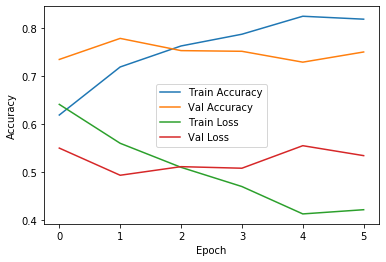

In [49]:
######################################## Halving no. of hidden Units####################################
cb = Callback()
cb_list = [cb]
es = EarlyStopping(monitor='val_accuracy', mode='max')
def vanilla_rnn():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 300, input_length=55, weights=[embedding_matrix], trainable=False))
    model.add(SimpleRNN(100, return_sequences = False))
    model.add(Dense(units=50, input_dim = 100, activation='sigmoid'))
    model.add(Dense(units=25, input_dim=50, activation='sigmoid'))
    model.add(Dense(units=1, input_dim=25,activation='sigmoid'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

model = KerasClassifier(build_fn = vanilla_rnn, epochs = 6, batch_size = 50, verbose = 1)

historyRNN=model.fit(train_sequences, training_label,validation_data=(dev_sequences,dev_label),callbacks=cb_list)

histRNN = pd.DataFrame(historyRNN.history)
histRNN['epoch'] = historyRNN.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(histRNN['epoch'], histRNN['acc'],
         label='Train Accuracy')
plt.plot(histRNN['epoch'], histRNN['val_acc'],
         label = 'Val Accuracy')
plt.plot(histRNN['epoch'], histRNN['loss'],
         label='Train Loss')
plt.plot(histRNN['epoch'], histRNN['val_loss'],
         label = 'Val Loss')
plt.legend()


Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 18s 3ms/sample - loss: 0.6276 - acc: 0.6459 - val_loss: 0.5882 - val_acc: 0.6921
Epoch 2/6
5402/5402 [==============================] - 17s 3ms/sample - loss: 0.5903 - acc: 0.6838 - val_loss: 0.5927 - val_acc: 0.6864
Epoch 3/6
5402/5402 [==============================] - 17s 3ms/sample - loss: 0.5523 - acc: 0.7194 - val_loss: 0.5227 - val_acc: 0.7345
Epoch 4/6
5402/5402 [==============================] - 17s 3ms/sample - loss: 0.5445 - acc: 0.7129 - val_loss: 0.5149 - val_acc: 0.7599
Epoch 5/6
5402/5402 [==============================] - 18s 3ms/sample - loss: 0.5237 - acc: 0.7368 - val_loss: 0.5197 - val_acc: 0.7556
Epoch 6/6
5402/5402 [==============================] - 17s 3ms/sample - loss: 0.5130 - acc: 0.7531 - val_loss: 0.5932 - val_acc: 0.6723


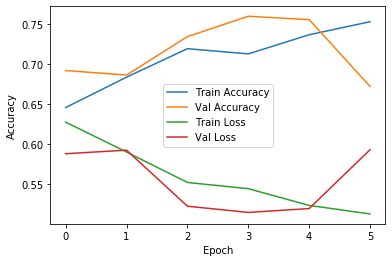

In [50]:
######################################## Doubling no. of hidden states####################################
cb = Callback()
cb_list = [cb]
es = EarlyStopping(monitor='val_accuracy', mode='max')
def vanilla_rnn():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 300, input_length=55, weights=[embedding_matrix], trainable=False))
    model.add(SimpleRNN(400, return_sequences = False))
    
    model.add(Dense(units=200, input_dim = 400, activation='sigmoid'))
    model.add(Dense(units=100, input_dim=200, activation='sigmoid'))
    
    model.add(Dense(units=1, input_dim=100,activation='sigmoid'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

model = KerasClassifier(build_fn = vanilla_rnn, epochs = 6, batch_size = 50, verbose = 1)

historyRNN=model.fit(train_sequences, training_label,validation_data=(dev_sequences,dev_label),callbacks=cb_list)

histRNN = pd.DataFrame(historyRNN.history)
histRNN['epoch'] = historyRNN.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(histRNN['epoch'], histRNN['acc'],
         label='Train Accuracy')
plt.plot(histRNN['epoch'], histRNN['val_acc'],
         label = 'Val Accuracy')
plt.plot(histRNN['epoch'], histRNN['loss'],
         label='Train Loss')
plt.plot(histRNN['epoch'], histRNN['val_loss'],
         label = 'Val Loss')
plt.legend()

Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 7s 1ms/sample - loss: 0.6222 - acc: 0.6457 - val_loss: 0.5211 - val_acc: 0.7472
Epoch 2/6
5402/5402 [==============================] - 5s 951us/sample - loss: 0.5210 - acc: 0.7495 - val_loss: 0.6366 - val_acc: 0.6624
Epoch 3/6
5402/5402 [==============================] - 5s 973us/sample - loss: 0.5265 - acc: 0.7421 - val_loss: 0.5806 - val_acc: 0.6907
Epoch 4/6
5402/5402 [==============================] - 6s 1ms/sample - loss: 0.4789 - acc: 0.7817 - val_loss: 0.6953 - val_acc: 0.6088
Epoch 5/6
5402/5402 [==============================] - 6s 1ms/sample - loss: 0.4490 - acc: 0.7951 - val_loss: 0.5676 - val_acc: 0.7302
Epoch 6/6
5402/5402 [==============================] - 6s 1ms/sample - loss: 0.3857 - acc: 0.8414 - val_loss: 0.5676 - val_acc: 0.7274


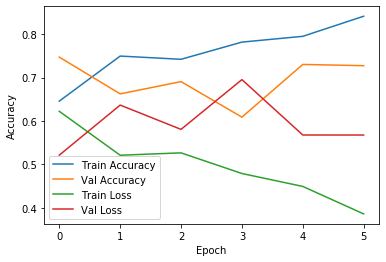

In [51]:
######################################## Sequence Size Half ############################################
train_sequences = tokenizer.texts_to_sequences(training_data)

train_sequences = pad_sequences(train_sequences, maxlen=27)

#######
test_sequences = tokenizer.texts_to_sequences(test_data)

test_sequences = pad_sequences(test_sequences, maxlen=27)
#######
dev_sequences = tokenizer.texts_to_sequences(dev_data)

dev_sequences = pad_sequences(dev_sequences, maxlen=27)
#######

cb = Callback()
cb_list = [cb]
es = EarlyStopping(monitor='val_accuracy', mode='max')
def vanilla_rnn():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 300, input_length=27, weights=[embedding_matrix], trainable=False))
    model.add(SimpleRNN(200, return_sequences = False))
    model.add(Dense(units=100, input_dim = 200, activation='sigmoid'))
    model.add(Dense(units=50, input_dim=100, activation='sigmoid'))
    model.add(Dense(units=1, input_dim=50,activation='sigmoid'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

model = KerasClassifier(build_fn = vanilla_rnn, epochs = 6, batch_size = 50, verbose = 1)

historyRNN=model.fit(train_sequences, training_label,validation_data=(dev_sequences,dev_label),callbacks=cb_list)

histRNN = pd.DataFrame(historyRNN.history)
histRNN['epoch'] = historyRNN.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(histRNN['epoch'], histRNN['acc'],
         label='Train Accuracy')
plt.plot(histRNN['epoch'], histRNN['val_acc'],
         label = 'Val Accuracy')
plt.plot(histRNN['epoch'], histRNN['loss'],
         label='Train Loss')
plt.plot(histRNN['epoch'], histRNN['val_loss'],
         label = 'Val Loss')
plt.legend()

Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 18s 3ms/sample - loss: 0.7128 - acc: 0.5056 - val_loss: 0.7316 - val_acc: 0.4718
Epoch 2/6
5402/5402 [==============================] - 17s 3ms/sample - loss: 0.6972 - acc: 0.5152 - val_loss: 0.6918 - val_acc: 0.6088
Epoch 3/6
5402/5402 [==============================] - 17s 3ms/sample - loss: 0.6929 - acc: 0.5130 - val_loss: 0.7004 - val_acc: 0.4718
Epoch 4/6
5402/5402 [==============================] - 17s 3ms/sample - loss: 0.7005 - acc: 0.5033 - val_loss: 0.6918 - val_acc: 0.5282
Epoch 5/6
5402/5402 [==============================] - 17s 3ms/sample - loss: 0.6941 - acc: 0.5152 - val_loss: 0.6963 - val_acc: 0.5282
Epoch 6/6
5402/5402 [==============================] - 16s 3ms/sample - loss: 0.6937 - acc: 0.5133 - val_loss: 0.6949 - val_acc: 0.4718


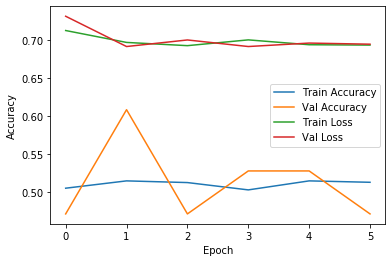

In [54]:
######################################## Sequence Size Double ############################################
train_sequences = tokenizer.texts_to_sequences(training_data)

train_sequences = pad_sequences(train_sequences, maxlen=110)

#######
test_sequences = tokenizer.texts_to_sequences(test_data)

test_sequences = pad_sequences(test_sequences, maxlen=110)
#######
dev_sequences = tokenizer.texts_to_sequences(dev_data)

dev_sequences = pad_sequences(dev_sequences, maxlen=110)
#######

cb = Callback()
cb_list = [cb]
es = EarlyStopping(monitor='val_accuracy', mode='max')
def vanilla_rnn():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 300, input_length=110, weights=[embedding_matrix], trainable=False))
    model.add(SimpleRNN(200, return_sequences = False))
    model.add(Dense(units=100, input_dim = 200, activation='sigmoid'))
    model.add(Dense(units=50, input_dim=100, activation='sigmoid'))
    model.add(Dense(units=1, input_dim=50,activation='sigmoid'))
    
    adam = optimizers.Adam(lr = 0.0051)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

model = KerasClassifier(build_fn = vanilla_rnn, epochs = 6, batch_size = 50, verbose = 1)

historyRNN=model.fit(train_sequences, training_label,validation_data=(dev_sequences,dev_label),callbacks=cb_list)

histRNN = pd.DataFrame(historyRNN.history)
histRNN['epoch'] = historyRNN.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(histRNN['epoch'], histRNN['acc'],
         label='Train Accuracy')
plt.plot(histRNN['epoch'], histRNN['val_acc'],
         label = 'Val Accuracy')
plt.plot(histRNN['epoch'], histRNN['loss'],
         label='Train Loss')
plt.plot(histRNN['epoch'], histRNN['val_loss'],
         label = 'Val Loss')
plt.legend()

In [55]:
#Changing to Glove 200D and using normal sequence length
words = []
idx = 0
word2idx = {}
embeddings_index = dict()
count=0
with open(f'glove/glove.6B.200d.txt', 'rb') as f:
    for line in f:
        count+=1
        if count==400000:
            print(count)
        values = line.decode().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

### TEXT TO SEQUENCING    
vocabulary_size = 100000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(all_data)

train_sequences = tokenizer.texts_to_sequences(training_data)

train_sequences = pad_sequences(train_sequences, maxlen=55)

#######
test_sequences = tokenizer.texts_to_sequences(test_data)

test_sequences = pad_sequences(test_sequences, maxlen=55)
#######
dev_sequences = tokenizer.texts_to_sequences(dev_data)

dev_sequences = pad_sequences(dev_sequences, maxlen=55)
#######


num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

400000


In [56]:
cb = Callback()
cb_list = [cb]
es = EarlyStopping(monitor='val_accuracy', mode='max')
def vanilla_rnn():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 200, input_length=55, weights=[embedding_matrix], trainable=False))
    model.add(SimpleRNN(200, return_sequences = False))
    model.add(Dense(units=100, input_dim = 200, activation='sigmoid'))
    model.add(Dense(units=50, input_dim=100, activation='sigmoid'))
    model.add(Dense(units=1, input_dim=50,activation='sigmoid'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

model = KerasClassifier(build_fn = vanilla_rnn, epochs = 6, batch_size = 50, verbose = 1)

historyRNN=model.fit(train_sequences, training_label,validation_data=(dev_sequences,dev_label),callbacks=cb_list)
##################################          END          ############################## 

Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 10s 2ms/sample - loss: 0.6592 - acc: 0.6029 - val_loss: 0.6046 - val_acc: 0.6822
Epoch 2/6
5402/5402 [==============================] - 9s 2ms/sample - loss: 0.5765 - acc: 0.7010 - val_loss: 0.5405 - val_acc: 0.7189
Epoch 3/6
5402/5402 [==============================] - 9s 2ms/sample - loss: 0.5280 - acc: 0.7431 - val_loss: 0.7759 - val_acc: 0.5678
Epoch 4/6
5402/5402 [==============================] - 9s 2ms/sample - loss: 0.5436 - acc: 0.7421 - val_loss: 0.4922 - val_acc: 0.7599
Epoch 5/6
5402/5402 [==============================] - 10s 2ms/sample - loss: 0.5423 - acc: 0.7408 - val_loss: 0.4860 - val_acc: 0.7797
Epoch 6/6
5402/5402 [==============================] - 9s 2ms/sample - loss: 0.4973 - acc: 0.7668 - val_loss: 0.4798 - val_acc: 0.7698


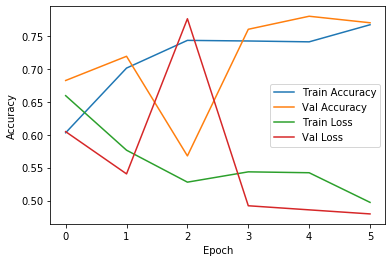

In [57]:
#Plot for above
histRNN = pd.DataFrame(historyRNN.history)
histRNN['epoch'] = historyRNN.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(histRNN['epoch'], histRNN['acc'],
         label='Train Accuracy')
plt.plot(histRNN['epoch'], histRNN['val_acc'],
         label = 'Val Accuracy')
plt.plot(histRNN['epoch'], histRNN['loss'],
         label='Train Loss')
plt.plot(histRNN['epoch'], histRNN['val_loss'],
         label = 'Val Loss')
plt.legend()

Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 8s 1ms/sample - loss: 0.7066 - acc: 0.5113 - val_loss: 0.6847 - val_acc: 0.5438
Epoch 2/6
5402/5402 [==============================] - 6s 1ms/sample - loss: 0.6310 - acc: 0.6483 - val_loss: 0.5452 - val_acc: 0.7542
Epoch 3/6
5402/5402 [==============================] - 7s 1ms/sample - loss: 0.5758 - acc: 0.6946 - val_loss: 0.5534 - val_acc: 0.7105
Epoch 4/6
5402/5402 [==============================] - 7s 1ms/sample - loss: 0.5510 - acc: 0.7258 - val_loss: 0.5005 - val_acc: 0.7853
Epoch 5/6
5402/5402 [==============================] - 7s 1ms/sample - loss: 0.5130 - acc: 0.7534 - val_loss: 0.5533 - val_acc: 0.7105
Epoch 6/6
5402/5402 [==============================] - 6s 1ms/sample - loss: 0.5488 - acc: 0.7251 - val_loss: 0.5087 - val_acc: 0.7641


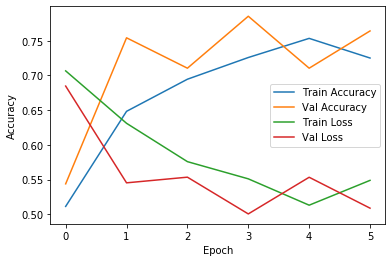

In [58]:
# Glove 200d with half no. of hidden states
cb = Callback()
cb_list = [cb]
es = EarlyStopping(monitor='val_accuracy', mode='max')
def vanilla_rnn():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 200, input_length=55, weights=[embedding_matrix], trainable=False))
    model.add(SimpleRNN(100, return_sequences = False))
    model.add(Dense(units=50, input_dim = 100, activation='sigmoid'))
    model.add(Dense(units=25, input_dim=50, activation='sigmoid'))
    model.add(Dense(units=1, input_dim=25,activation='sigmoid'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

model = KerasClassifier(build_fn = vanilla_rnn, epochs = 6, batch_size = 50, verbose = 1)

historyRNN=model.fit(train_sequences, training_label,validation_data=(dev_sequences,dev_label),callbacks=cb_list)

histRNN = pd.DataFrame(historyRNN.history)
histRNN['epoch'] = historyRNN.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(histRNN['epoch'], histRNN['acc'],
         label='Train Accuracy')
plt.plot(histRNN['epoch'], histRNN['val_acc'],
         label = 'Val Accuracy')
plt.plot(histRNN['epoch'], histRNN['loss'],
         label='Train Loss')
plt.plot(histRNN['epoch'], histRNN['val_loss'],
         label = 'Val Loss')
plt.legend()

Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 18s 3ms/sample - loss: 0.6833 - acc: 0.5678 - val_loss: 0.6700 - val_acc: 0.5607
Epoch 2/6
5402/5402 [==============================] - 16s 3ms/sample - loss: 0.6413 - acc: 0.6268 - val_loss: 0.5671 - val_acc: 0.7090
Epoch 3/6
5402/5402 [==============================] - 16s 3ms/sample - loss: 0.5741 - acc: 0.7079 - val_loss: 0.5816 - val_acc: 0.6681
Epoch 4/6
5402/5402 [==============================] - 16s 3ms/sample - loss: 0.6066 - acc: 0.6655 - val_loss: 0.5874 - val_acc: 0.6554
Epoch 5/6
5402/5402 [==============================] - 17s 3ms/sample - loss: 0.5510 - acc: 0.7142 - val_loss: 0.5018 - val_acc: 0.7698
Epoch 6/6
5402/5402 [==============================] - 16s 3ms/sample - loss: 0.5606 - acc: 0.7049 - val_loss: 0.5519 - val_acc: 0.7316


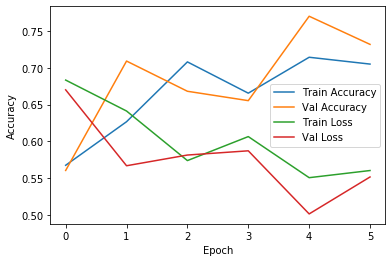

In [59]:
#GLove 200d with double hidden states
cb = Callback()
cb_list = [cb]
es = EarlyStopping(monitor='val_accuracy', mode='max')
def vanilla_rnn():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 200, input_length=55, weights=[embedding_matrix], trainable=False))
    model.add(SimpleRNN(400, return_sequences = False))
    
    model.add(Dense(units=200, input_dim = 400, activation='sigmoid'))
    model.add(Dense(units=100, input_dim=200, activation='sigmoid'))
    
    model.add(Dense(units=1, input_dim=100,activation='sigmoid'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

model = KerasClassifier(build_fn = vanilla_rnn, epochs = 6, batch_size = 50, verbose = 1)

historyRNN=model.fit(train_sequences, training_label,validation_data=(dev_sequences,dev_label),callbacks=cb_list)

histRNN = pd.DataFrame(historyRNN.history)
histRNN['epoch'] = historyRNN.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(histRNN['epoch'], histRNN['acc'],
         label='Train Accuracy')
plt.plot(histRNN['epoch'], histRNN['val_acc'],
         label = 'Val Accuracy')
plt.plot(histRNN['epoch'], histRNN['loss'],
         label='Train Loss')
plt.plot(histRNN['epoch'], histRNN['val_loss'],
         label = 'Val Loss')
plt.legend()

Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 7s 1ms/sample - loss: 0.6617 - acc: 0.5964 - val_loss: 0.5647 - val_acc: 0.7274
Epoch 2/6
5402/5402 [==============================] - 6s 1ms/sample - loss: 0.5584 - acc: 0.7197 - val_loss: 0.5229 - val_acc: 0.7514
Epoch 3/6
5402/5402 [==============================] - 5s 996us/sample - loss: 0.5431 - acc: 0.7320 - val_loss: 0.4769 - val_acc: 0.7825
Epoch 4/6
5402/5402 [==============================] - 6s 1ms/sample - loss: 0.5475 - acc: 0.7207 - val_loss: 0.5832 - val_acc: 0.6907
Epoch 5/6
5402/5402 [==============================] - 5s 980us/sample - loss: 0.5275 - acc: 0.7392 - val_loss: 0.4704 - val_acc: 0.7571
Epoch 6/6
5402/5402 [==============================] - 6s 1ms/sample - loss: 0.5079 - acc: 0.7588 - val_loss: 0.5712 - val_acc: 0.7232


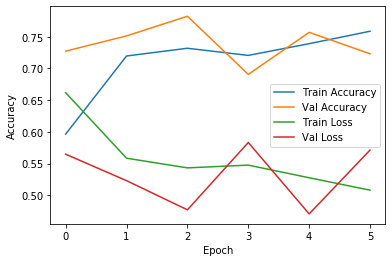

In [60]:
#Glove 200d with half sequence length
train_sequences = tokenizer.texts_to_sequences(training_data)

train_sequences = pad_sequences(train_sequences, maxlen=27)

#######
test_sequences = tokenizer.texts_to_sequences(test_data)

test_sequences = pad_sequences(test_sequences, maxlen=27)
#######
dev_sequences = tokenizer.texts_to_sequences(dev_data)

dev_sequences = pad_sequences(dev_sequences, maxlen=27)
#######

cb = Callback()
cb_list = [cb]
es = EarlyStopping(monitor='val_accuracy', mode='max')
def vanilla_rnn():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 200, input_length=27, weights=[embedding_matrix], trainable=False))
    model.add(SimpleRNN(200, return_sequences = False))
    model.add(Dense(units=100, input_dim = 200, activation='sigmoid'))
    model.add(Dense(units=50, input_dim=100, activation='sigmoid'))
    model.add(Dense(units=1, input_dim=50,activation='sigmoid'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

model = KerasClassifier(build_fn = vanilla_rnn, epochs = 6, batch_size = 50, verbose = 1)

historyRNN=model.fit(train_sequences, training_label,validation_data=(dev_sequences,dev_label),callbacks=cb_list)

histRNN = pd.DataFrame(historyRNN.history)
histRNN['epoch'] = historyRNN.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(histRNN['epoch'], histRNN['acc'],
         label='Train Accuracy')
plt.plot(histRNN['epoch'], histRNN['val_acc'],
         label = 'Val Accuracy')
plt.plot(histRNN['epoch'], histRNN['loss'],
         label='Train Loss')
plt.plot(histRNN['epoch'], histRNN['val_loss'],
         label = 'Val Loss')
plt.legend()

Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 18s 3ms/sample - loss: 0.7044 - acc: 0.5094 - val_loss: 0.6939 - val_acc: 0.4718
Epoch 2/6
5402/5402 [==============================] - 16s 3ms/sample - loss: 0.6961 - acc: 0.5030 - val_loss: 0.6915 - val_acc: 0.5282
Epoch 3/6
5402/5402 [==============================] - 18s 3ms/sample - loss: 0.6955 - acc: 0.4987 - val_loss: 0.6938 - val_acc: 0.4718
Epoch 4/6
5402/5402 [==============================] - 16s 3ms/sample - loss: 0.6946 - acc: 0.5074 - val_loss: 0.6922 - val_acc: 0.5282
Epoch 5/6
5402/5402 [==============================] - 16s 3ms/sample - loss: 0.6932 - acc: 0.5146 - val_loss: 0.6914 - val_acc: 0.5282
Epoch 6/6
5402/5402 [==============================] - 17s 3ms/sample - loss: 0.6889 - acc: 0.5324 - val_loss: 0.7164 - val_acc: 0.5282


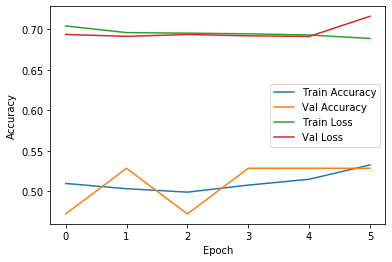

In [61]:
#Glove 200d with double sequence size
train_sequences = tokenizer.texts_to_sequences(training_data)

train_sequences = pad_sequences(train_sequences, maxlen=110)

#######
test_sequences = tokenizer.texts_to_sequences(test_data)

test_sequences = pad_sequences(test_sequences, maxlen=110)
#######
dev_sequences = tokenizer.texts_to_sequences(dev_data)

dev_sequences = pad_sequences(dev_sequences, maxlen=110)
#######

cb = Callback()
cb_list = [cb]
es = EarlyStopping(monitor='val_accuracy', mode='max')
def vanilla_rnn():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 200, input_length=110, weights=[embedding_matrix], trainable=False))
    model.add(SimpleRNN(200, return_sequences = False))
    model.add(Dense(units=100, input_dim = 200, activation='sigmoid'))
    model.add(Dense(units=50, input_dim=100, activation='sigmoid'))
    model.add(Dense(units=1, input_dim=50,activation='sigmoid'))
    
    adam = optimizers.Adam(lr = 0.0051)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

model = KerasClassifier(build_fn = vanilla_rnn, epochs = 6, batch_size = 50, verbose = 1)

historyRNN=model.fit(train_sequences, training_label,validation_data=(dev_sequences,dev_label),callbacks=cb_list)

histRNN = pd.DataFrame(historyRNN.history)
histRNN['epoch'] = historyRNN.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(histRNN['epoch'], histRNN['acc'],
         label='Train Accuracy')
plt.plot(histRNN['epoch'], histRNN['val_acc'],
         label = 'Val Accuracy')
plt.plot(histRNN['epoch'], histRNN['loss'],
         label='Train Loss')
plt.plot(histRNN['epoch'], histRNN['val_loss'],
         label = 'Val Loss')
plt.legend()

In [62]:
#glove 100d with normal sequence length

words = []
idx = 0
word2idx = {}
embeddings_index = dict()
count=0
with open(f'glove/glove.6B.100d.txt', 'rb') as f:
    for line in f:
        count+=1
        if count==50000:
            print(count)
        if count==100000:
            print(count)
        if count==200000:
            print(count)
        if count==400000:
            print(count)
        values = line.decode().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

### TEXT TO SEQUENCING    
vocabulary_size = 100000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(all_data)

train_sequences = tokenizer.texts_to_sequences(training_data)

train_sequences = pad_sequences(train_sequences, maxlen=55)

#######
test_sequences = tokenizer.texts_to_sequences(test_data)

test_sequences = pad_sequences(test_sequences, maxlen=55)
#######
dev_sequences = tokenizer.texts_to_sequences(dev_data)

dev_sequences = pad_sequences(dev_sequences, maxlen=55)
#######


num_words = 100000
embedding_matrix = np.zeros((num_words, 100))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

50000
100000
200000
400000


In [63]:
cb = Callback()
cb_list = [cb]
es = EarlyStopping(monitor='val_accuracy', mode='max')
def vanilla_rnn():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 100, input_length=55, weights=[embedding_matrix], trainable=False))
    model.add(SimpleRNN(200, return_sequences = False))
    model.add(Dense(units=100, input_dim = 200, activation='sigmoid'))
    model.add(Dense(units=50, input_dim=100, activation='sigmoid'))
    model.add(Dense(units=1, input_dim=50,activation='sigmoid'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

model = KerasClassifier(build_fn = vanilla_rnn, epochs = 6, batch_size = 50, verbose = 1)

historyRNN=model.fit(train_sequences, training_label,validation_data=(dev_sequences,dev_label),callbacks=cb_list)
##################################          END          ############################## 

Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 10s 2ms/sample - loss: 0.6680 - acc: 0.5790 - val_loss: 0.6706 - val_acc: 0.6088
Epoch 2/6
5402/5402 [==============================] - 9s 2ms/sample - loss: 0.6439 - acc: 0.6246 - val_loss: 0.6712 - val_acc: 0.5805
Epoch 3/6
5402/5402 [==============================] - 8s 2ms/sample - loss: 0.6088 - acc: 0.6668 - val_loss: 0.5503 - val_acc: 0.7274
Epoch 4/6
5402/5402 [==============================] - 8s 2ms/sample - loss: 0.5852 - acc: 0.6955 - val_loss: 0.5736 - val_acc: 0.7119
Epoch 5/6
5402/5402 [==============================] - 8s 2ms/sample - loss: 0.5719 - acc: 0.7068 - val_loss: 0.5335 - val_acc: 0.7528
Epoch 6/6
5402/5402 [==============================] - 9s 2ms/sample - loss: 0.5631 - acc: 0.7144 - val_loss: 0.5043 - val_acc: 0.7613


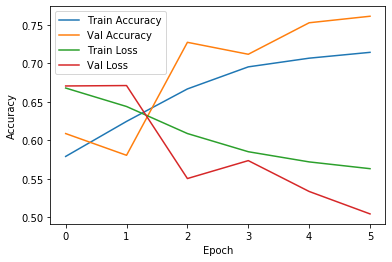

In [64]:
#Plot for above
histRNN = pd.DataFrame(historyRNN.history)
histRNN['epoch'] = historyRNN.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(histRNN['epoch'], histRNN['acc'],
         label='Train Accuracy')
plt.plot(histRNN['epoch'], histRNN['val_acc'],
         label = 'Val Accuracy')
plt.plot(histRNN['epoch'], histRNN['loss'],
         label='Train Loss')
plt.plot(histRNN['epoch'], histRNN['val_loss'],
         label = 'Val Loss')

plt.legend()

Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 7s 1ms/sample - loss: 0.6498 - acc: 0.6129 - val_loss: 0.5991 - val_acc: 0.6751
Epoch 2/6
5402/5402 [==============================] - 5s 949us/sample - loss: 0.5821 - acc: 0.6986 - val_loss: 0.5764 - val_acc: 0.7133
Epoch 3/6
5402/5402 [==============================] - 5s 899us/sample - loss: 0.5704 - acc: 0.7114 - val_loss: 0.5805 - val_acc: 0.7175
Epoch 4/6
5402/5402 [==============================] - 5s 938us/sample - loss: 0.5536 - acc: 0.7214 - val_loss: 0.6876 - val_acc: 0.6384
Epoch 5/6
5402/5402 [==============================] - 5s 926us/sample - loss: 0.5528 - acc: 0.7195 - val_loss: 0.5343 - val_acc: 0.7189
Epoch 6/6
5402/5402 [==============================] - 5s 938us/sample - loss: 0.4783 - acc: 0.7805 - val_loss: 0.5368 - val_acc: 0.7331


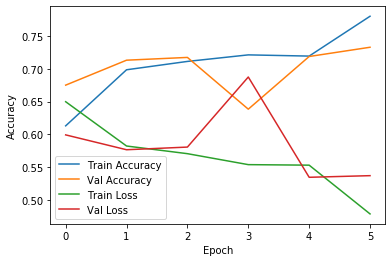

In [65]:
#Glove 100d with half sequence length
train_sequences = tokenizer.texts_to_sequences(training_data)

train_sequences = pad_sequences(train_sequences, maxlen=27)

#######
test_sequences = tokenizer.texts_to_sequences(test_data)

test_sequences = pad_sequences(test_sequences, maxlen=27)
#######
dev_sequences = tokenizer.texts_to_sequences(dev_data)

dev_sequences = pad_sequences(dev_sequences, maxlen=27)
#######

cb = Callback()
cb_list = [cb]
es = EarlyStopping(monitor='val_accuracy', mode='max')
def vanilla_rnn():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 100, input_length=27, weights=[embedding_matrix], trainable=False))
    model.add(SimpleRNN(200, return_sequences = False))
    model.add(Dense(units=100, input_dim = 200, activation='sigmoid'))
    model.add(Dense(units=50, input_dim=100, activation='sigmoid'))
    model.add(Dense(units=1, input_dim=50,activation='sigmoid'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

model = KerasClassifier(build_fn = vanilla_rnn, epochs = 6, batch_size = 50, verbose = 1)

historyRNN=model.fit(train_sequences, training_label,validation_data=(dev_sequences,dev_label),callbacks=cb_list)

histRNN = pd.DataFrame(historyRNN.history)
histRNN['epoch'] = historyRNN.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(histRNN['epoch'], histRNN['acc'],
         label='Train Accuracy')
plt.plot(histRNN['epoch'], histRNN['val_acc'],
         label = 'Val Accuracy')
plt.plot(histRNN['epoch'], histRNN['loss'],
         label='Train Loss')
plt.plot(histRNN['epoch'], histRNN['val_loss'],
         label = 'Val Loss')
plt.legend()

Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 18s 3ms/sample - loss: 0.7017 - acc: 0.4981 - val_loss: 0.6878 - val_acc: 0.5282
Epoch 2/6
5402/5402 [==============================] - 15s 3ms/sample - loss: 0.6844 - acc: 0.5553 - val_loss: 0.6767 - val_acc: 0.6215
Epoch 3/6
5402/5402 [==============================] - 15s 3ms/sample - loss: 0.6691 - acc: 0.5902 - val_loss: 0.6702 - val_acc: 0.5975
Epoch 4/6
5402/5402 [==============================] - 15s 3ms/sample - loss: 0.6691 - acc: 0.5892 - val_loss: 0.6622 - val_acc: 0.6441
Epoch 5/6
5402/5402 [==============================] - 15s 3ms/sample - loss: 0.6567 - acc: 0.6111 - val_loss: 0.6737 - val_acc: 0.5975
Epoch 6/6
5402/5402 [==============================] - 15s 3ms/sample - loss: 0.6665 - acc: 0.5957 - val_loss: 0.6498 - val_acc: 0.6441


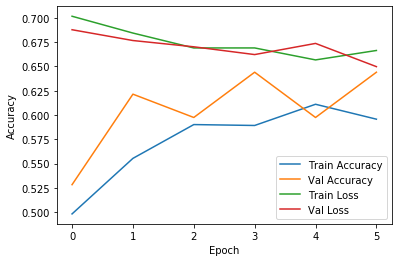

In [66]:
#Glove 100d with double sequence size
train_sequences = tokenizer.texts_to_sequences(training_data)

train_sequences = pad_sequences(train_sequences, maxlen=110)

#######
test_sequences = tokenizer.texts_to_sequences(test_data)

test_sequences = pad_sequences(test_sequences, maxlen=110)
#######
dev_sequences = tokenizer.texts_to_sequences(dev_data)

dev_sequences = pad_sequences(dev_sequences, maxlen=110)
#######

cb = Callback()
cb_list = [cb]
es = EarlyStopping(monitor='val_accuracy', mode='max')
def vanilla_rnn():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 100, input_length=110, weights=[embedding_matrix], trainable=False))
    model.add(SimpleRNN(200, return_sequences = False))
    model.add(Dense(units=100, input_dim = 200, activation='sigmoid'))
    model.add(Dense(units=50, input_dim=100, activation='sigmoid'))
    model.add(Dense(units=1, input_dim=50,activation='sigmoid'))
    
    adam = optimizers.Adam(lr = 0.0051)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

model = KerasClassifier(build_fn = vanilla_rnn, epochs = 6, batch_size = 50, verbose = 1)

historyRNN=model.fit(train_sequences, training_label,validation_data=(dev_sequences,dev_label),callbacks=cb_list)

histRNN = pd.DataFrame(historyRNN.history)
histRNN['epoch'] = historyRNN.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(histRNN['epoch'], histRNN['acc'],
         label='Train Accuracy')
plt.plot(histRNN['epoch'], histRNN['val_acc'],
         label = 'Val Accuracy')
plt.plot(histRNN['epoch'], histRNN['loss'],
         label='Train Loss')
plt.plot(histRNN['epoch'], histRNN['val_loss'],
         label = 'Val Loss')
plt.legend()

Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 7s 1ms/sample - loss: 0.6747 - acc: 0.5820 - val_loss: 0.6473 - val_acc: 0.6102
Epoch 2/6
5402/5402 [==============================] - 6s 1ms/sample - loss: 0.6170 - acc: 0.6622 - val_loss: 0.5879 - val_acc: 0.6949
Epoch 3/6
5402/5402 [==============================] - 6s 1ms/sample - loss: 0.6068 - acc: 0.6753 - val_loss: 0.5504 - val_acc: 0.7429
Epoch 4/6
5402/5402 [==============================] - 6s 1ms/sample - loss: 0.5716 - acc: 0.7116 - val_loss: 0.5213 - val_acc: 0.7514
Epoch 5/6
5402/5402 [==============================] - 6s 1ms/sample - loss: 0.5502 - acc: 0.7264 - val_loss: 0.5052 - val_acc: 0.7585
Epoch 6/6
5402/5402 [==============================] - 6s 1ms/sample - loss: 0.5276 - acc: 0.7438 - val_loss: 0.5598 - val_acc: 0.7288


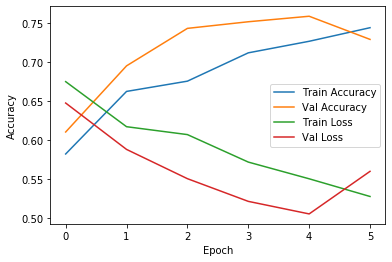

In [67]:
# Glove 100d with half no. of hidden units
train_sequences = tokenizer.texts_to_sequences(training_data)

train_sequences = pad_sequences(train_sequences, maxlen=55)

#######
test_sequences = tokenizer.texts_to_sequences(test_data)

test_sequences = pad_sequences(test_sequences, maxlen=55)
#######
dev_sequences = tokenizer.texts_to_sequences(dev_data)

dev_sequences = pad_sequences(dev_sequences, maxlen=55)
#######

cb = Callback()
cb_list = [cb]
es = EarlyStopping(monitor='val_accuracy', mode='max')
def vanilla_rnn():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 100, input_length=55, weights=[embedding_matrix], trainable=False))
    model.add(SimpleRNN(100, return_sequences = False))
    model.add(Dense(units=50, input_dim = 100, activation='sigmoid'))
    model.add(Dense(units=25, input_dim = 50, activation='sigmoid'))
    model.add(Dense(units=1, input_dim=25,activation='sigmoid'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

model = KerasClassifier(build_fn = vanilla_rnn, epochs = 6, batch_size = 50, verbose = 1)

historyRNN=model.fit(train_sequences, training_label,validation_data=(dev_sequences,dev_label),callbacks=cb_list)

histRNN = pd.DataFrame(historyRNN.history)
histRNN['epoch'] = historyRNN.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(histRNN['epoch'], histRNN['acc'],
         label='Train Accuracy')
plt.plot(histRNN['epoch'], histRNN['val_acc'],
         label = 'Val Accuracy')
plt.plot(histRNN['epoch'], histRNN['loss'],
         label='Train Loss')
plt.plot(histRNN['epoch'], histRNN['val_loss'],
         label = 'Val Loss')
plt.legend()

Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 8s 1ms/sample - loss: 0.6601 - acc: 0.6053 - val_loss: 0.5413 - val_acc: 0.7655: 0.6614 - acc: 0.
Epoch 2/6
5402/5402 [==============================] - 5s 954us/sample - loss: 0.5791 - acc: 0.7031 - val_loss: 0.5612 - val_acc: 0.7274
Epoch 3/6
5402/5402 [==============================] - 5s 948us/sample - loss: 0.5589 - acc: 0.7184 - val_loss: 0.5206 - val_acc: 0.7444
Epoch 4/6
5402/5402 [==============================] - 5s 968us/sample - loss: 0.5298 - acc: 0.7438 - val_loss: 0.5681 - val_acc: 0.7076
Epoch 5/6
5402/5402 [==============================] - 5s 970us/sample - loss: 0.5210 - acc: 0.7475 - val_loss: 0.4929 - val_acc: 0.7740
Epoch 6/6
5402/5402 [==============================] - 5s 952us/sample - loss: 0.4879 - acc: 0.7779 - val_loss: 0.5124 - val_acc: 0.7613


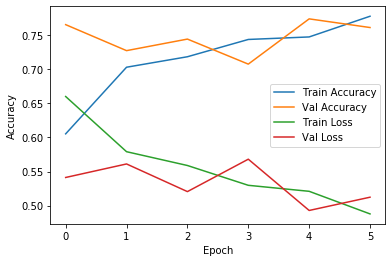

In [68]:
#GLove 100d with double hidden states
train_sequences = tokenizer.texts_to_sequences(training_data)

train_sequences = pad_sequences(train_sequences, maxlen=55)

#######
test_sequences = tokenizer.texts_to_sequences(test_data)

test_sequences = pad_sequences(test_sequences, maxlen=55)
#######
dev_sequences = tokenizer.texts_to_sequences(dev_data)

dev_sequences = pad_sequences(dev_sequences, maxlen=55)
#######
cb = Callback()
cb_list = [cb]
es = EarlyStopping(monitor='val_accuracy', mode='max')
def vanilla_rnn():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 100, input_length=55, weights=[embedding_matrix], trainable=False))
    model.add(SimpleRNN(100, return_sequences = False))
    
    model.add(Dense(units=50, input_dim = 100, activation='sigmoid'))
    model.add(Dense(units=25, input_dim=50, activation='sigmoid'))
    
    model.add(Dense(units=1, input_dim=25,activation='sigmoid'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

model = KerasClassifier(build_fn = vanilla_rnn, epochs = 6, batch_size = 50, verbose = 1)

historyRNN=model.fit(train_sequences, training_label,validation_data=(dev_sequences,dev_label),callbacks=cb_list)

histRNN = pd.DataFrame(historyRNN.history)
histRNN['epoch'] = historyRNN.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(histRNN['epoch'], histRNN['acc'],
         label='Train Accuracy')
plt.plot(histRNN['epoch'], histRNN['val_acc'],
         label = 'Val Accuracy')
plt.plot(histRNN['epoch'], histRNN['loss'],
         label='Train Loss')
plt.plot(histRNN['epoch'], histRNN['val_loss'],
         label = 'Val Loss')
plt.legend()

In [69]:
#Glove 50d for normal size of sequence
words = []
idx = 0
word2idx = {}
embeddings_index = dict()
count=0
with open(f'glove/glove.6B.50d.txt', 'rb') as f:
    for line in f:
        count+=1
        if count==100000:
            print(count)
        if count==400000:
            print(count)
        values = line.decode().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

### TEXT TO SEQUENCING    
vocabulary_size = 100000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(all_data)

train_sequences = tokenizer.texts_to_sequences(training_data)

train_sequences = pad_sequences(train_sequences, maxlen=55)

#######
test_sequences = tokenizer.texts_to_sequences(test_data)

test_sequences = pad_sequences(test_sequences, maxlen=55)
#######
dev_sequences = tokenizer.texts_to_sequences(dev_data)

dev_sequences = pad_sequences(dev_sequences, maxlen=55)
#######


num_words = 100000
embedding_matrix = np.zeros((num_words, 50))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100000
400000


In [70]:
cb = Callback()
cb_list = [cb]
es = EarlyStopping(monitor='val_accuracy', mode='max')
def vanilla_rnn():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 50, input_length=55, weights=[embedding_matrix], trainable=False))
    model.add(SimpleRNN(200, return_sequences = False))
    model.add(Dense(units=100, input_dim = 200, activation='sigmoid'))
    model.add(Dense(units=50, input_dim=100, activation='sigmoid'))
    model.add(Dense(units=1, input_dim=50,activation='sigmoid'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

model = KerasClassifier(build_fn = vanilla_rnn, epochs = 6, batch_size = 50, verbose = 1)

historyRNN=model.fit(train_sequences, training_label,validation_data=(dev_sequences,dev_label),callbacks=cb_list)
##################################          END          ############################## 

Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 10s 2ms/sample - loss: 0.6624 - acc: 0.6001 - val_loss: 0.5944 - val_acc: 0.7006
Epoch 2/6
5402/5402 [==============================] - 8s 2ms/sample - loss: 0.6148 - acc: 0.6592 - val_loss: 0.6799 - val_acc: 0.6215
Epoch 3/6
5402/5402 [==============================] - 8s 1ms/sample - loss: 0.6322 - acc: 0.6440 - val_loss: 0.5836 - val_acc: 0.7090
Epoch 4/6
5402/5402 [==============================] - 8s 1ms/sample - loss: 0.5892 - acc: 0.6925 - val_loss: 0.6370 - val_acc: 0.6610
Epoch 5/6
5402/5402 [==============================] - 8s 2ms/sample - loss: 0.5874 - acc: 0.6957 - val_loss: 0.5896 - val_acc: 0.6921
Epoch 6/6
5402/5402 [==============================] - 8s 2ms/sample - loss: 0.5741 - acc: 0.7034 - val_loss: 0.5552 - val_acc: 0.7161


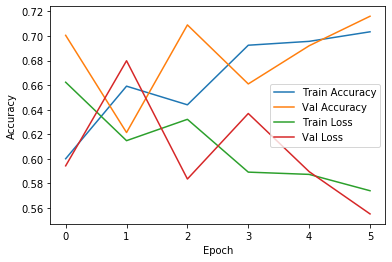

In [71]:
#Plot for above
histRNN = pd.DataFrame(historyRNN.history)
histRNN['epoch'] = historyRNN.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(histRNN['epoch'], histRNN['acc'],
         label='Train Accuracy')
plt.plot(histRNN['epoch'], histRNN['val_acc'],
         label = 'Val Accuracy')
plt.plot(histRNN['epoch'], histRNN['loss'],
         label='Train Loss')
plt.plot(histRNN['epoch'], histRNN['val_loss'],
         label = 'Val Loss')
plt.legend()

Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 7s 1ms/sample - loss: 0.6720 - acc: 0.5809 - val_loss: 0.6168 - val_acc: 0.6638
Epoch 2/6
5402/5402 [==============================] - 5s 836us/sample - loss: 0.6210 - acc: 0.6564 - val_loss: 0.5865 - val_acc: 0.6822
Epoch 3/6
5402/5402 [==============================] - 5s 861us/sample - loss: 0.6355 - acc: 0.6418 - val_loss: 0.6418 - val_acc: 0.6469
Epoch 4/6
5402/5402 [==============================] - 5s 863us/sample - loss: 0.5993 - acc: 0.6833 - val_loss: 0.5671 - val_acc: 0.7260
Epoch 5/6
5402/5402 [==============================] - 5s 883us/sample - loss: 0.6069 - acc: 0.6796 - val_loss: 0.5476 - val_acc: 0.7373
Epoch 6/6
5402/5402 [==============================] - 6s 1ms/sample - loss: 0.5912 - acc: 0.6847 - val_loss: 0.5540 - val_acc: 0.7373


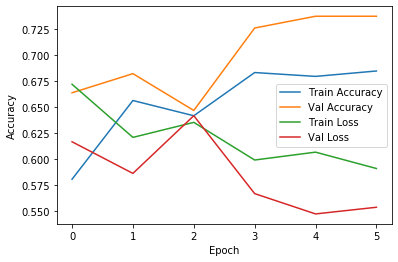

In [72]:
#Glove 50d with half sequence length
train_sequences = tokenizer.texts_to_sequences(training_data)

train_sequences = pad_sequences(train_sequences, maxlen=27)

#######
test_sequences = tokenizer.texts_to_sequences(test_data)

test_sequences = pad_sequences(test_sequences, maxlen=27)
#######
dev_sequences = tokenizer.texts_to_sequences(dev_data)

dev_sequences = pad_sequences(dev_sequences, maxlen=27)
#######

cb = Callback()
cb_list = [cb]
es = EarlyStopping(monitor='val_accuracy', mode='max')
def vanilla_rnn():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 50, input_length=27, weights=[embedding_matrix], trainable=False))
    model.add(SimpleRNN(200, return_sequences = False))
    model.add(Dense(units=100, input_dim = 200, activation='sigmoid'))
    model.add(Dense(units=50, input_dim=100, activation='sigmoid'))
    model.add(Dense(units=1, input_dim=50,activation='sigmoid'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

model = KerasClassifier(build_fn = vanilla_rnn, epochs = 6, batch_size = 50, verbose = 1)

historyRNN=model.fit(train_sequences, training_label,validation_data=(dev_sequences,dev_label),callbacks=cb_list)

histRNN = pd.DataFrame(historyRNN.history)
histRNN['epoch'] = historyRNN.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(histRNN['epoch'], histRNN['acc'],
         label='Train Accuracy')
plt.plot(histRNN['epoch'], histRNN['val_acc'],
         label = 'Val Accuracy')
plt.plot(histRNN['epoch'], histRNN['loss'],
         label='Train Loss')
plt.plot(histRNN['epoch'], histRNN['val_loss'],
         label = 'Val Loss')
plt.legend()

Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 18s 3ms/sample - loss: 0.7009 - acc: 0.5081 - val_loss: 0.6910 - val_acc: 0.5749
Epoch 2/6
5402/5402 [==============================] - 13s 2ms/sample - loss: 0.6963 - acc: 0.5207 - val_loss: 0.7013 - val_acc: 0.5282
Epoch 3/6
5402/5402 [==============================] - 13s 2ms/sample - loss: 0.6972 - acc: 0.5137 - val_loss: 0.6881 - val_acc: 0.5339
Epoch 4/6
5402/5402 [==============================] - 14s 3ms/sample - loss: 0.6705 - acc: 0.5940 - val_loss: 0.6128 - val_acc: 0.6893
Epoch 5/6
5402/5402 [==============================] - 13s 2ms/sample - loss: 0.6634 - acc: 0.5989 - val_loss: 0.6381 - val_acc: 0.6497
Epoch 6/6
5402/5402 [==============================] - 16s 3ms/sample - loss: 0.6553 - acc: 0.6148 - val_loss: 0.6148 - val_acc: 0.6893


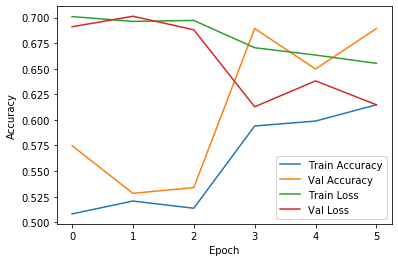

In [73]:
#Glove 50d with double sequence size
train_sequences = tokenizer.texts_to_sequences(training_data)

train_sequences = pad_sequences(train_sequences, maxlen=110)

#######
test_sequences = tokenizer.texts_to_sequences(test_data)

test_sequences = pad_sequences(test_sequences, maxlen=110)
#######
dev_sequences = tokenizer.texts_to_sequences(dev_data)

dev_sequences = pad_sequences(dev_sequences, maxlen=110)
#######

cb = Callback()
cb_list = [cb]
es = EarlyStopping(monitor='val_accuracy', mode='max')
def vanilla_rnn():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 50, input_length=110, weights=[embedding_matrix], trainable=False))
    model.add(SimpleRNN(200, return_sequences = False))
    model.add(Dense(units=100, input_dim = 200, activation='sigmoid'))
    model.add(Dense(units=50, input_dim=100, activation='sigmoid'))
    model.add(Dense(units=1, input_dim=50,activation='sigmoid'))
    
    adam = optimizers.Adam(lr = 0.0051)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

model = KerasClassifier(build_fn = vanilla_rnn, epochs = 6, batch_size = 50, verbose = 1)

historyRNN=model.fit(train_sequences, training_label,validation_data=(dev_sequences,dev_label),callbacks=cb_list)

histRNN = pd.DataFrame(historyRNN.history)
histRNN['epoch'] = historyRNN.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(histRNN['epoch'], histRNN['acc'],
         label='Train Accuracy')
plt.plot(histRNN['epoch'], histRNN['val_acc'],
         label = 'Val Accuracy')
plt.plot(histRNN['epoch'], histRNN['loss'],
         label='Train Loss')
plt.plot(histRNN['epoch'], histRNN['val_loss'],
         label = 'Val Loss')
plt.legend()

Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 7s 1ms/sample - loss: 0.6654 - acc: 0.5940 - val_loss: 0.5960 - val_acc: 0.6893
Epoch 2/6
5402/5402 [==============================] - 5s 964us/sample - loss: 0.6201 - acc: 0.6592 - val_loss: 0.5486 - val_acc: 0.7246
Epoch 3/6
5402/5402 [==============================] - 5s 939us/sample - loss: 0.5936 - acc: 0.6847 - val_loss: 0.5443 - val_acc: 0.7331
Epoch 4/6
5402/5402 [==============================] - 5s 1ms/sample - loss: 0.5954 - acc: 0.6810 - val_loss: 0.5559 - val_acc: 0.7246
Epoch 5/6
5402/5402 [==============================] - 5s 1ms/sample - loss: 0.5725 - acc: 0.7094 - val_loss: 0.5334 - val_acc: 0.7429
Epoch 6/6
5402/5402 [==============================] - 6s 1ms/sample - loss: 0.5441 - acc: 0.7318 - val_loss: 0.5311 - val_acc: 0.7316


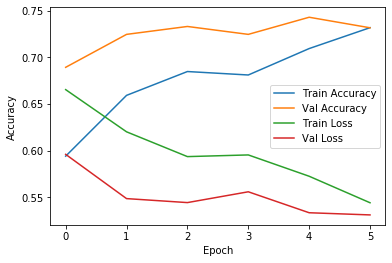

In [74]:
# Glove 50d with half no. of hidden states
train_sequences = tokenizer.texts_to_sequences(training_data)

train_sequences = pad_sequences(train_sequences, maxlen=55)

#######
test_sequences = tokenizer.texts_to_sequences(test_data)

test_sequences = pad_sequences(test_sequences, maxlen=55)
#######
dev_sequences = tokenizer.texts_to_sequences(dev_data)

dev_sequences = pad_sequences(dev_sequences, maxlen=55)
#######

cb = Callback()
cb_list = [cb]
es = EarlyStopping(monitor='val_accuracy', mode='max')
def vanilla_rnn():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 50, input_length=55, weights=[embedding_matrix], trainable=False))
    model.add(SimpleRNN(100, return_sequences = False))
    model.add(Dense(units=50, input_dim = 100, activation='sigmoid'))
    model.add(Dense(units=25, input_dim = 50, activation='sigmoid'))
    model.add(Dense(units=1, input_dim=25,activation='sigmoid'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

model = KerasClassifier(build_fn = vanilla_rnn, epochs = 6, batch_size = 50, verbose = 1)

historyRNN=model.fit(train_sequences, training_label,validation_data=(dev_sequences,dev_label),callbacks=cb_list)

histRNN = pd.DataFrame(historyRNN.history)
histRNN['epoch'] = historyRNN.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(histRNN['epoch'], histRNN['acc'],
         label='Train Accuracy')
plt.plot(histRNN['epoch'], histRNN['val_acc'],
         label = 'Val Accuracy')
plt.plot(histRNN['epoch'], histRNN['loss'],
         label='Train Loss')
plt.plot(histRNN['epoch'], histRNN['val_loss'],
         label = 'Val Loss')
plt.legend()

Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 17s 3ms/sample - loss: 0.6936 - acc: 0.5385 - val_loss: 0.6823 - val_acc: 0.6073
Epoch 2/6
5402/5402 [==============================] - 16s 3ms/sample - loss: 0.6752 - acc: 0.5755 - val_loss: 0.6811 - val_acc: 0.5311
Epoch 3/6
5402/5402 [==============================] - 17s 3ms/sample - loss: 0.7021 - acc: 0.5189 - val_loss: 0.6866 - val_acc: 0.5367
Epoch 4/6
5402/5402 [==============================] - 15s 3ms/sample - loss: 0.6878 - acc: 0.5328 - val_loss: 0.6796 - val_acc: 0.5904
Epoch 5/6
5402/5402 [==============================] - 15s 3ms/sample - loss: 0.6730 - acc: 0.5846 - val_loss: 0.6368 - val_acc: 0.6554
Epoch 6/6
5402/5402 [==============================] - 16s 3ms/sample - loss: 0.6414 - acc: 0.6459 - val_loss: 0.6258 - val_acc: 0.6695


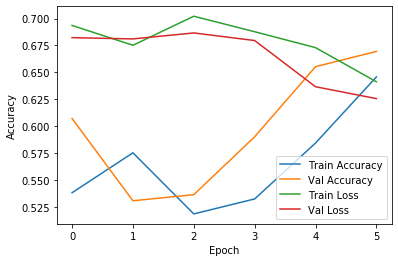

In [75]:
#GLove 50d with double hidden units
train_sequences = tokenizer.texts_to_sequences(training_data)

train_sequences = pad_sequences(train_sequences, maxlen=55)

#######
test_sequences = tokenizer.texts_to_sequences(test_data)

test_sequences = pad_sequences(test_sequences, maxlen=55)
#######
dev_sequences = tokenizer.texts_to_sequences(dev_data)

dev_sequences = pad_sequences(dev_sequences, maxlen=55)
#######
cb = Callback()
cb_list = [cb]
es = EarlyStopping(monitor='val_accuracy', mode='max')
def vanilla_rnn():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 50, input_length=55, weights=[embedding_matrix], trainable=False))
    model.add(SimpleRNN(400, return_sequences = False))
    
    model.add(Dense(units=200, input_dim = 400, activation='sigmoid'))
    model.add(Dense(units=100, input_dim=200, activation='sigmoid'))
    
    model.add(Dense(units=1, input_dim=100,activation='sigmoid'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

model = KerasClassifier(build_fn = vanilla_rnn, epochs = 6, batch_size = 50, verbose = 1)

historyRNN=model.fit(train_sequences, training_label,validation_data=(dev_sequences,dev_label),callbacks=cb_list)

histRNN = pd.DataFrame(historyRNN.history)
histRNN['epoch'] = historyRNN.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(histRNN['epoch'], histRNN['acc'],
         label='Train Accuracy')
plt.plot(histRNN['epoch'], histRNN['val_acc'],
         label = 'Val Accuracy')
plt.plot(histRNN['epoch'], histRNN['loss'],
         label='Train Loss')
plt.plot(histRNN['epoch'], histRNN['val_loss'],
         label = 'Val Loss')
plt.legend()

In [11]:
### Final model

#glove to dictionary
words = []
idx = 0
word2idx = {}
embeddings_index = dict()
count=0
print("Glove to dictionary")
with open(f'glove/glove.6B.300d.txt', 'rb') as f:
    for line in f:
        count+=1
        if count==50000:
            print(count)
        if count==200000:
            print(count)
        if count==400000:
            print(count," Done")
        values = line.decode().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


Glove to dictionary
50000
200000
400000  Done


In [14]:
train_sequences = tokenizer.texts_to_sequences(training_data)

train_sequences = pad_sequences(train_sequences, maxlen=27)

#######
test_sequences = tokenizer.texts_to_sequences(test_data)

test_sequences = pad_sequences(test_sequences, maxlen=27)
#######
dev_sequences = tokenizer.texts_to_sequences(dev_data)

dev_sequences = pad_sequences(dev_sequences, maxlen=27)
#######



In [15]:
#Creating embedding matrix
num_words = 100000
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [17]:
## Final Model
 
################################## Model for LSTM #####################################
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 300, input_length=27, 
                          weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))

model_glove.add(LSTM(200))

model_glove.add(Dense(units=100, input_dim = 200, activation='sigmoid'))
model_glove.add(Dense(units=50, input_dim = 100, activation='sigmoid'))

model_glove.add(Dense(units=1, input_dim=50, activation='sigmoid'))

model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
historyLSTM=model_glove.fit(train_sequences,training_label,epochs=6,validation_data=(dev_sequences,dev_label))
##################################          END          ##############################



W1028 22:24:58.227000  2740 deprecation.py:323] From E:\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 39s 7ms/sample - loss: 0.5943 - acc: 0.6909 - val_loss: 0.4717 - val_acc: 0.7811
Epoch 2/6
5402/5402 [==============================] - 35s 7ms/sample - loss: 0.4749 - acc: 0.7756 - val_loss: 0.4405 - val_acc: 0.7853
Epoch 3/6
5402/5402 [==============================] - 37s 7ms/sample - loss: 0.4258 - acc: 0.8029 - val_loss: 0.4191 - val_acc: 0.7924
Epoch 4/6
5402/5402 [==============================] - 36s 7ms/sample - loss: 0.3788 - acc: 0.8277 - val_loss: 0.4247 - val_acc: 0.7895
Epoch 5/6
5402/5402 [==============================] - 36s 7ms/sample - loss: 0.3391 - acc: 0.8536 - val_loss: 0.4378 - val_acc: 0.7910
Epoch 6/6
5402/5402 [==============================] - 36s 7ms/sample - loss: 0.2781 - acc: 0.8843 - val_loss: 0.4573 - val_acc: 0.8037


NameError: name 'historyRNN' is not defined

In [39]:
pred=model_glove.predict_classes(test_sequences,verbose=0)
#tl=test_label.flatten()
#tl=tl.tolist()
#pred
acc=accuracy_score(tl,pred)
print(acc)
precision=precision_score(tl,pred)
print(precision)
recall=recall_score(tl,pred)
print(recall)
f1=f1_score(tl,pred)
print(f1)

0.786366830639494
0.7933333333333333
0.7997311827956989
0.7965194109772423


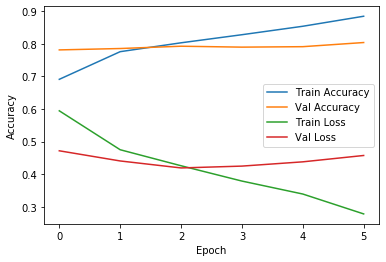

In [19]:
histRNN = pd.DataFrame(historyLSTM.history)
histRNN['epoch'] = historyLSTM.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(histRNN['epoch'], histRNN['acc'],
         label='Train Accuracy')
plt.plot(histRNN['epoch'], histRNN['val_acc'],
         label = 'Val Accuracy')
plt.plot(histRNN['epoch'], histRNN['loss'],
         label='Train Loss')
plt.plot(histRNN['epoch'], histRNN['val_loss'],
         label = 'Val Loss')
plt.legend()

In [21]:
#### GRU with new parameters
modelGRU = Sequential()
modelGRU.add(Embedding(vocabulary_size, 300, input_length=27, weights=[embedding_matrix], trainable=False))
modelGRU.add(GRU(200))
modelGRU.add(Dense(units=100, input_dim = 200, activation='sigmoid'))
modelGRU.add(Dense(units=50, input_dim = 100, activation='sigmoid'))
modelGRU.add(Dense(1, input_dim = 50, activation='sigmoid'))
modelGRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
historyGRU=modelGRU.fit(train_sequences, training_label,validation_data=(dev_sequences,dev_label), epochs=6)

Train on 5402 samples, validate on 708 samples
Epoch 1/6
5402/5402 [==============================] - 40s 7ms/sample - loss: 0.5466 - acc: 0.7121 - val_loss: 0.4677 - val_acc: 0.7938
Epoch 2/6
5402/5402 [==============================] - 39s 7ms/sample - loss: 0.4246 - acc: 0.8062 - val_loss: 0.4872 - val_acc: 0.7895
Epoch 3/6
5402/5402 [==============================] - 39s 7ms/sample - loss: 0.3686 - acc: 0.8354 - val_loss: 0.4443 - val_acc: 0.7867
Epoch 4/6
5402/5402 [==============================] - 39s 7ms/sample - loss: 0.2971 - acc: 0.8821 - val_loss: 0.4596 - val_acc: 0.7924
Epoch 5/6
5402/5402 [==============================] - 40s 7ms/sample - loss: 0.2034 - acc: 0.9247 - val_loss: 0.5676 - val_acc: 0.7895
Epoch 6/6
5402/5402 [==============================] - 40s 7ms/sample - loss: 0.1210 - acc: 0.9615 - val_loss: 0.6070 - val_acc: 0.8079


       loss       acc  val_loss   val_acc  epoch
0  0.546603  0.712144  0.467730  0.793785      0
1  0.424582  0.806183  0.487163  0.789548      1
2  0.368601  0.835431  0.444323  0.786723      2
3  0.297055  0.882081  0.459606  0.792373      3
4  0.203414  0.924658  0.567585  0.789548      4
5  0.120996  0.961496  0.606995  0.807910      5


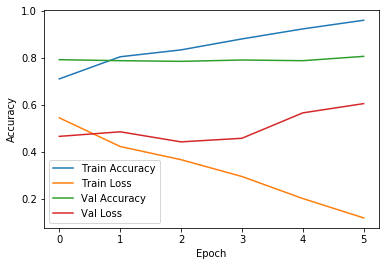

In [40]:
histGRU = pd.DataFrame(historyGRU.history)
histGRU['epoch'] = historyGRU.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
print (histGRU)
plt.plot(histGRU['epoch'], histGRU['acc'],
         label='Train Accuracy')
plt.plot(histGRU['epoch'], histGRU['loss'],
         label='Train Loss')
plt.plot(histGRU['epoch'], histGRU['val_acc'],
         label = 'Val Accuracy')
plt.plot(histGRU['epoch'], histGRU['val_loss'],
         label = 'Val Loss')
plt.legend()

In [41]:
pred=modelGRU.predict_classes(test_sequences,verbose=0)
acc=accuracy_score(tl,pred)
print(acc)
precision=precision_score(tl,pred)
print(precision)
recall=recall_score(tl,pred)
print(recall)
f1=f1_score(tl,pred)
print(f1)

0.7835558678847505
0.7898936170212766
0.7983870967741935
0.7941176470588235
